# Awal-awal

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import statsmodels.api as sm
import itertools
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import ConvLSTM2D
from keras.layers import RepeatVector
plt.style.use('ggplot')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!git clone https://github.com/aeramu/bri-data.git

Cloning into 'bri-data'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 12 (delta 0), reused 12 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.


In [ ]:
train_path = '/content/bri-data/cro/train.csv'
test_path = '/content/bri-data/cro/test.csv'
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
train_data.head()

,periode,cash_in_echannel,cash_out_echannel,cash_in_kantor,cash_out_kantor,cr_ketetapan_total_bkn_sum,giro,deposito,kewajiban_lain,tabungan,rata_dpk_mingguan,kas_kantor,kas_echannel
0,2019-07-31,7.303000e+08,-1.304400e+09,1.436722e+11,-1.106104e+11,3.0,9.867358e+11,8.048153e+11,1.419685e+10,7.072647e+11,3.135744e+11,1.928940e+09,2.939100e+09
1,2019-08-01,7.322000e+08,-8.321500e+08,3.144131e+11,-6.710987e+10,3.0,8.962459e+11,8.125611e+11,1.234062e+10,7.011995e+11,3.135744e+11,2.492322e+11,2.839150e+09
2,2019-08-02,1.169800e+09,-6.214000e+08,1.251294e+09,-1.142332e+09,3.0,9.059714e+11,8.127225e+11,1.182022e+10,6.922787e+11,3.135744e+11,2.493411e+11,3.387550e+09
3,2019-08-03,9.134500e+08,-4.240500e+08,0.000000e+00,0.000000e+00,3.0,9.057127e+11,8.127253e+11,1.199640e+10,6.867224e+11,3.135744e+11,2.493411e+11,3.876950e+09
4,2019-08-04,7.752500e+08,-7.779500e+08,9.883331e+10,-8.729274e+10,3.0,9.788347e+11,8.124711e+11,1.232962e+10,6.813438e+11,3.135744e+11,2.608817e+11,3.874250e+09


# Univariate LSTM

## Data Preparation

In [ ]:
from sklearn import preprocessing
data = {}
for col in train_data.columns[1:].tolist():
  col_data = np.array(train_data[col])
  col_data = col_data.reshape(-1,1)
  std_scale = preprocessing.StandardScaler().fit(col_data)
  col_norm = std_scale.transform(col_data)
  col_norm_list = [i[0] for i in col_norm]
  data[col] = col_norm_list

In [ ]:
train = pd.DataFrame(data=data)
train.head()

,cash_in_echannel,cash_out_echannel,cash_in_kantor,cash_out_kantor,cr_ketetapan_total_bkn_sum,giro,deposito,kewajiban_lain,tabungan,rata_dpk_mingguan,kas_kantor,kas_echannel
0,0.078876,-1.622216,0.582655,-0.914961,0.0,0.273088,-0.500682,0.127086,0.266117,0.115972,-1.769231,-0.798188
1,0.084435,-0.356361,2.428609,-0.081392,0.0,0.038749,-0.460206,-0.419198,0.210593,0.115972,-1.693102,-0.895885
2,1.364780,0.208550,-0.957119,1.182696,0.0,0.063935,-0.459363,-0.572348,0.128927,0.115972,-1.693068,-0.359850
3,0.614742,0.737542,-0.970647,1.204585,0.0,0.063265,-0.459348,-0.520500,0.078061,0.115972,-1.693068,0.118514
4,0.210392,-0.211079,0.097883,-0.468142,0.0,0.252627,-0.460677,-0.422435,0.028823,0.115972,-1.689515,0.115875


In [ ]:
def scaling(col):
  col_data = np.array(train_data[col])
  col_data = col_data.reshape(-1,1)
  std_scale = preprocessing.StandardScaler().fit(col_data)
  return std_scale

In [ ]:
def reverse_scale(scale,datas):
  arr = np.array(datas)
  arr = arr.reshape(-1,1)
  return scale.transform(arr)

In [ ]:
# univariate data preparation
from numpy import array
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 

In [ ]:
def input_data(kolom,n_steps,normalize):
  if normalize:
    # define input sequence
    raw_seq = train[kolom].tolist()
  else:
    raw_seq = train_data[kolom].tolist()
  # split into samples
  X, y = split_sequence(raw_seq, n_steps)
  return X,y


## Vanilla LSTM

In [ ]:
def vanilla_model(n_steps,X,y,n_features):
  # reshape from [samples, timesteps] into [samples, timesteps, features]
  X = X.reshape((X.shape[0], X.shape[1], n_features))
  # define model
  model = Sequential()
  model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  # fit model
  model.fit(X, y, epochs=200, verbose=0)
  return model


## Stacked LSTM

In [ ]:
def stacked_model(n_steps,X,y,n_features):
  # reshape from [samples, timesteps] into [samples, timesteps, features]
  X = X.reshape((X.shape[0], X.shape[1], n_features))
  # define model
  model = Sequential()
  model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
  model.add(LSTM(50, activation='relu'))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  # fit model
  model.fit(X, y, epochs=200, verbose=0)
  return model

## Bidirectional LSTM

In [ ]:
from keras.layers import Bidirectional
def bidirectional_model(n_steps,X,y,n_features):
  # reshape from [samples, timesteps] into [samples, timesteps, features]
  X = X.reshape((X.shape[0], X.shape[1], n_features))
  # define model
  model = Sequential()
  model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  # fit model
  model.fit(X, y, epochs=200, verbose=0)
  return model


## CNN

In [ ]:
def CNN_model(n_steps,X,y,n_features,n_seq):
  n_steps = 2
  # reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
  X = X.reshape((X.shape[0], n_seq, n_steps, n_features))
  # define model
  model = Sequential()
  model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
  model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(50, activation='relu'))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  # fit model
  model.fit(X, y, epochs=500, verbose=0)
  return model

## ConvLSTM

In [ ]:
def ConvLSTM_model(n_steps,X,y,n_features,n_seq):
  n_steps = 2
  X = X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))
  # define model
  model = Sequential()
  model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
  model.add(Flatten())
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  # fit model
  model.fit(X, y, epochs=500, verbose=0)
  return model

In [ ]:
d = {}
d['a'] = [1,2,3]
d['a'].append(4)
d['a']

[1, 2, 3, 4]

## Kas Kantor

In [ ]:
def predict_value(model_name,koloms,n_steps,n_features,n_seq,normalize):

  #initialize
  scales = {}
  outputs = {}
  kas_t1 = train_data.iloc[-1]['kas_kantor']#get first kas(kas t-1)

  #train model for each kolom
  for kolom in koloms:
    X,y = input_data(kolom,n_steps,normalize)
    if model_name == 'vanilla':
      model = vanilla_model(n_steps,X,y,n_features)
    elif model_name == 'stacked':
      model = stacked_model(n_steps,X,y,n_features)
    elif model_name == 'CNN':
      model = CNN_model(n_steps,X,y,n_features,n_seq)
    elif model_name == 'ConvLSTM':
      model = ConvLSTM_model(n_steps,X,y,n_features,n_seq)
    else:
      model = bidirectional_model(n_steps,X,y,n_features)
    
    #Make scales
    scales[kolom] = scaling(kolom)

    #initialize input for prediction
    x_input = np.array(train.tail(n_steps)[kolom].tolist())  
    output = []

    # prediction for 30 day
    for i in range(30):
      #reshape input
      if model_name == 'CNN':
        n_steps_cnn = 2
        x_reshape = x_input.reshape((1, n_seq, n_steps_cnn, n_features))
      elif model_name == 'ConvLSTM':
        n_steps_conv = 2
        x_reshape = x_input.reshape((1, n_seq, 1, n_steps_conv, n_features))
      else:
        x_reshape = x_input.reshape((1, n_steps, n_features))
      yhat = model.predict(x_reshape, verbose=0)
      x_input = x_input[1:n_steps]
      x_input = np.append(x_input,yhat)
      output.append(yhat.tolist()[0][0])
    outputs[kolom] = output
  
  #find kas kantor
  final = final_value(kas_t1,outputs,scales)
  return final, outputs

In [ ]:
def final_value(kas_t1,in_and_out,scales):
  kas_list = []
  keys = list(in_and_out.keys())
  print(keys)
  norm = {}
  #reverse scaling
  for key in keys:
    norm[key] = reverse_scale(scales[key],in_and_out[key])

  #Sum kas kantor
  for i in range(30):
    kas = 0
    if i == 0:
      kas = kas_t1 + norm[keys[0]][i][0] + norm[keys[1]][i][0]
    else:
      kas = kas_list[i-1]  + norm[keys[0]][i][0] + norm[keys[1]][i][0]
    kas_list.append(kas)

  return kas_list


In [ ]:
def plot(model_name,koloms,n_steps,n_features,n_seq,normalize=True):
  final, outputs = predict_value(model_name,koloms,n_steps,n_features,n_seq,normalize)
  fig, axs = plt.subplots(3,2,figsize=(20, 5))
  x = [i for i in range(1,31)]
  row = 0
  for key in list(outputs.keys()):
    col = 0
    y = train_data.iloc[-30:][key]
    axs[row,col].plot(x , y)
    axs[row,col].set_title(f'{key} dari data asli')

    col += 1
    y = outputs[key]
    axs[row,col].plot(x , y)
    axs[row,col].set_title(f'{key} dari model {model_name}')
    row += 1
  
  axs[2,0].plot(x , train_data.iloc[-30:]['kas_kantor'])
  axs[2,0].set_title(f'{key} dari data asli')

  axs[2,1].plot(x , final)
  axs[2,1].set_title(f'{key} dari data model')
  plt.show()


['cash_in_kantor', 'cash_out_kantor']


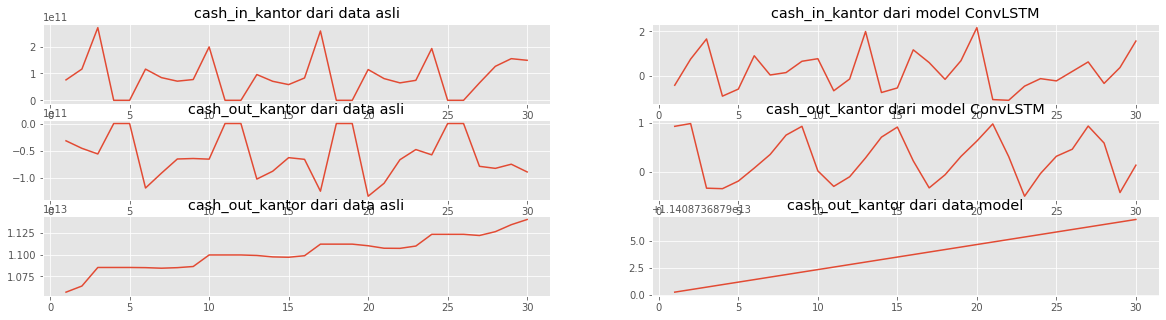

In [ ]:
plot('ConvLSTM',['cash_in_kantor','cash_out_kantor'],4,1,2)

(421, 2, 2, 1)
dict_keys(['kas_kantor'])
(421, 2, 2, 1)
dict_keys(['kas_kantor', 'cash_in_kantor'])
(421, 2, 2, 1)
dict_keys(['kas_kantor', 'cash_in_kantor', 'cash_out_kantor'])


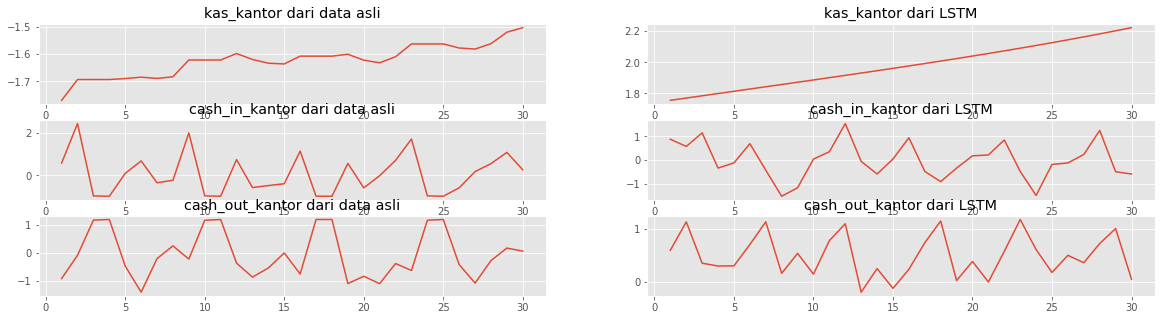

In [ ]:
plot('CNN',['kas_kantor','cash_in_kantor','cash_out_kantor'],4,1,2)

(4,)
dict_keys(['kas_kantor'])
(4,)
dict_keys(['kas_kantor', 'cash_in_kantor'])
(4,)
dict_keys(['kas_kantor', 'cash_in_kantor', 'cash_out_kantor'])


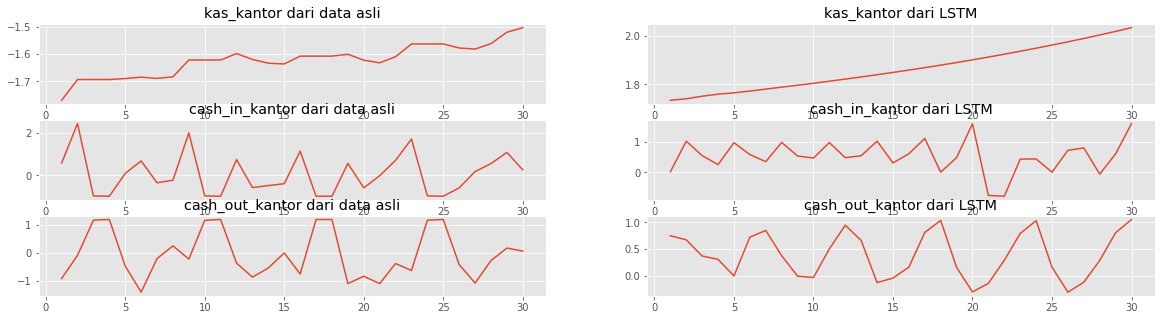

In [ ]:
plot('vanilla',['kas_kantor','cash_in_kantor','cash_out_kantor'],4,1,2)

dict_keys(['kas_kantor'])
dict_keys(['kas_kantor', 'cash_in_kantor'])
dict_keys(['kas_kantor', 'cash_in_kantor', 'cash_out_kantor'])


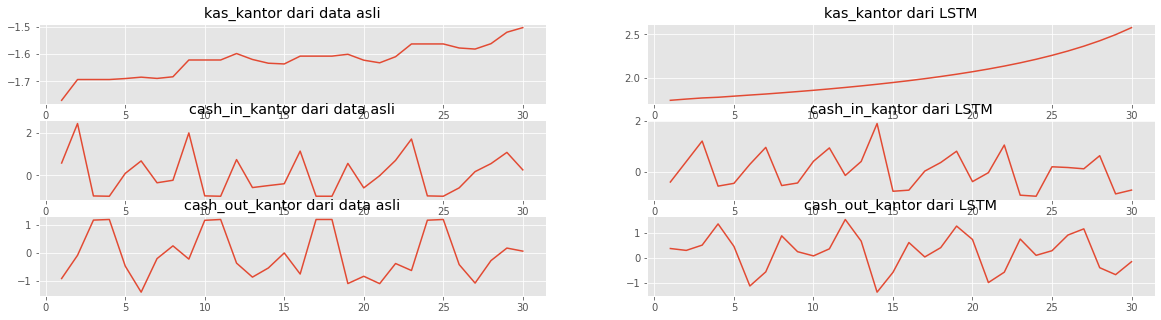

In [ ]:
plot('stacked',['kas_kantor','cash_in_kantor','cash_out_kantor'],3,1)

dict_keys(['kas_kantor'])
dict_keys(['kas_kantor', 'cash_in_kantor'])
dict_keys(['kas_kantor', 'cash_in_kantor', 'cash_out_kantor'])


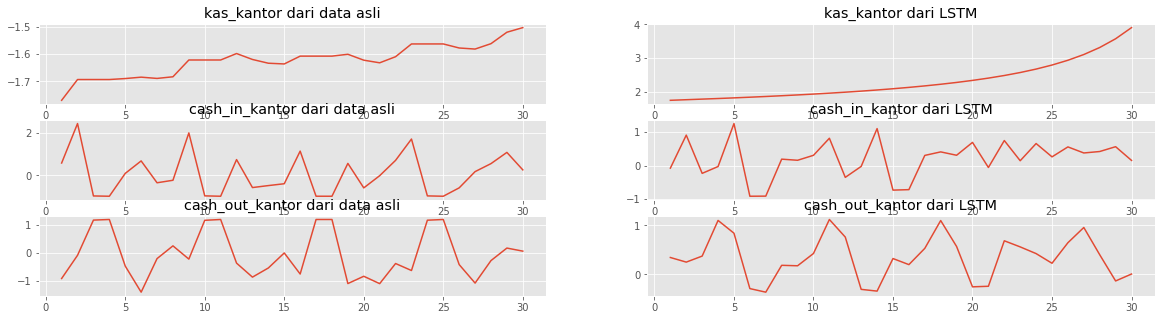

In [ ]:
plot('bidirectional',['kas_kantor','cash_in_kantor','cash_out_kantor'],3,1)

# Multistep LSTM

## Data Preparation

In [ ]:
# split a univariate sequence into samples
def split_sequence_multistep(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
def input_data_multistep(kolom,n_steps_in,n_steps_out,normalize):
  if normalize:
    # define input sequence
    raw_seq = train[kolom].tolist()
  else:
    raw_seq = train_data[kolom].tolist()
  # split into samples
  X, y = split_sequence_multistep(raw_seq, n_steps_in, n_steps_out)
  return X,y

## Vector Output Model

In [ ]:
def vector_model(n_steps_in,n_steps_out,X,y,n_features):
  X = X.reshape((X.shape[0], X.shape[1], n_features))
  # define model
  model = Sequential()
  model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
  model.add(LSTM(100, activation='relu'))
  model.add(Dense(n_steps_out))
  model.compile(optimizer='adam', loss='mse')
  return model

## Encoder Decoder Model

In [ ]:
def encoder_decoder_model(n_steps_in,n_steps_out,X,y,n_features):
  X = X.reshape((X.shape[0], X.shape[1], n_features))
  y = y.reshape((y.shape[0], y.shape[1], n_features))
  # define model
  model = Sequential()
  model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
  model.add(RepeatVector(n_steps_out))
  model.add(LSTM(100, activation='relu', return_sequences=True))
  model.add(TimeDistributed(Dense(1)))
  model.compile(optimizer='adam', loss='mse')
  # fit model
  model.fit(X, y, epochs=100, verbose=0)
  return model

## Kas Kantor

In [ ]:
def kas_kantor_multistep(model_name,koloms,n_steps_in,n_steps_out,n_features,normalize):
  outputs = {}
  for kolom in koloms:
    X,y = input_data_multistep(kolom,n_steps_in,n_steps_out,normalize)
    if model_name == 'vector':
      #train model for each kolom
      model = vector_model(n_steps_in,n_steps_out,X,y,n_features)
    else:
      model = encoder_decoder_model(n_steps_in,n_steps_out,X,y,n_features)
    # prediction for 30 day
    x_input = np.array(train.tail(n_steps_in)[kolom].tolist())  
    output = []
    for i in range(30):
      #reshape input
      x_reshape = x_input.reshape((1, n_steps_in, n_features))
      yhat = model.predict(x_reshape, verbose=0)
      x_input = x_input[1:n_steps]
      x_input = np.append(x_input,yhat)
      output.append(yhat.tolist()[0][0])
    outputs[kolom] = output
  return outputs

In [ ]:
def plot_multistep(model_name,koloms,n_steps_in,n_steps_out,n_features,normalize=True):
  outputs = kas_kantor_multistep(model_name,koloms,n_steps_in,n_steps_out,n_features,normalize)
  fig, axs = plt.subplots(3,2,figsize=(20, 5))
  x = [i for i in range(1,31)]
  row = 0
  for key in list(outputs.keys()):
    col = 0
    y = train.iloc[:30][key]
    axs[row,col].plot(x , y)
    axs[row,col].set_title(f'{key} dari data asli')

    col += 1
    y = outputs[key]
    axs[row,col].plot(x , y)
    axs[row,col].set_title(f'{key} dari model {model_name}')
    row += 1
  plt.show()

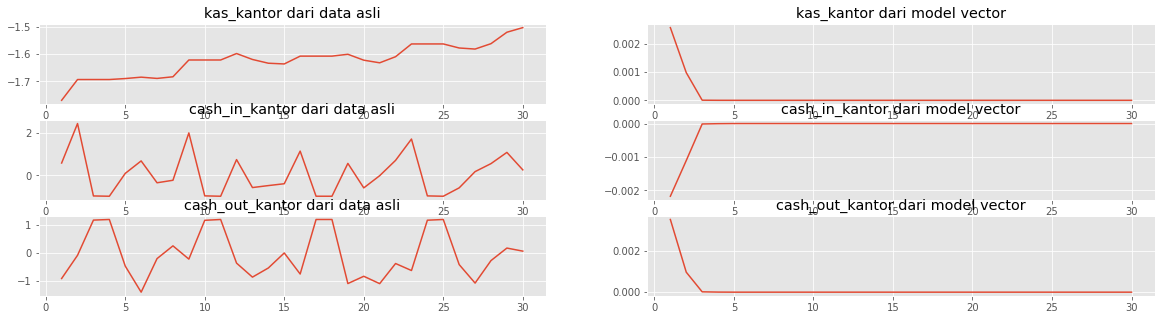

In [ ]:
plot_multistep('vector', ['kas_kantor','cash_in_kantor','cash_out_kantor'],3,2,1)

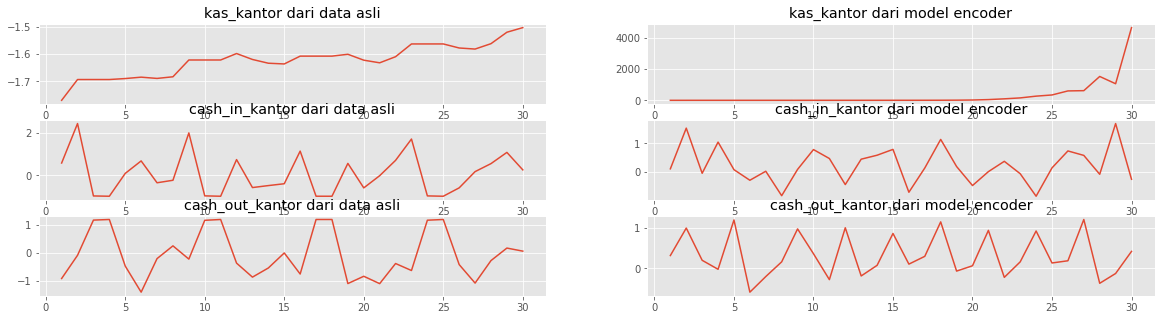

In [ ]:
plot_multistep('encoder', ['kas_kantor','cash_in_kantor','cash_out_kantor'],3,2,1)